<font size="5px">**Detecção de Fake News com Redes Neurais Recorrentes**</font><br>

<p align='justify'>
<b>Definição do problema: </b> a partir uma base de dados, classificar se uma notícia é falsa ou verdadeira por meio da arquitetura de redes neurais recorrentes.<br><br>
<b>Base de dados: </b> a base de dados foi obtida da competição do kaggle de 2017 para reconhecimento de <i>Fake new</i>. Pode ser encontrado link: <a href='https://www.kaggle.com/c/fake-news/data'>www.kaggle.com/fake-news</a>
</p>


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

from keras import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

plt.style.use('ggplot')

# Montagem da base

<p align='justify'>
&nbsp;&nbsp;&nbsp;&nbsp;Como base foram utilizados os dados disponíveis para a competição kaggle no desafio de montagem de um sistema que identifique notícias não confiáveis. Além disso, foram utilizadas bases de dados de outros participantes, assim criando uma base maior, contendo, ao todo, aproximadamente 44 mil registros. Sendo esses, divididos em duas bases diferentes, um contendo notícias verdadeiras, e outro contendo notícias falsas, com proporções similares entre as duas. Essas bases contendo as seguintes colunas:
</p>
<ul>
<li>title: título da notícia</li>
<li>text: conteudo da noticia, podendo por vezes estar incompleto</li>
<li>subject: assunto da notícia</li>
<li>date: data de publicação</li>
</ul>

In [ ]:
_fake_news_dataset_url = 'https://github.com/rover-solutions/fake-new-detection-demo/raw/main/data/fake_news.csv'
_fake_news_data = pd.read_csv(_fake_news_dataset_url)

_reliable_news_dataset_url = 'https://github.com/rover-solutions/fake-new-detection-demo/raw/main/data/reliable_news.csv'
_reliable_news_data = pd.read_csv(_reliable_news_dataset_url)

_fake_news_data

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [ ]:
_fake_news_data.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
_fake_news_data.drop(['date', 'subject'], axis=1, inplace=True)
_reliable_news_data.drop(['date', 'subject'], axis=1, inplace=True)

In [ ]:
_fake_news_data['class'] = 0 
_reliable_news_data['class'] = 1

In [ ]:
_fake_news_data['class'].count()

23481

Text(0, 0.5, 'Proporção de artigos de notícias')

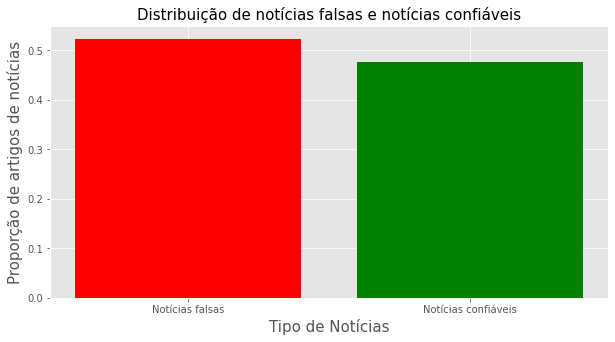

In [ ]:
_size_fake_news, _size_reliable_new = len(_fake_news_data), len(_reliable_news_data)
_total_record = _size_fake_news + _size_reliable_new

plt.figure(figsize=(10, 5))
plt.bar('Notícias falsas', _size_fake_news / _total_record, color='red')
plt.bar('Notícias confiáveis', _size_reliable_new / _total_record, color='green')
plt.title('Distribuição de notícias falsas e notícias confiáveis', size=15)
plt.xlabel('Tipo de Notícias', size=15)
plt.ylabel('Proporção de artigos de notícias', size=15)

#Tratamento dos dados

<p align="justify">Para o treinamento do modelo, fora concatenadas as colunas title e text, isso por que, ambas as colunas possuem uma relação muito íntima na determinação da varassidade de uma noticia, portanto não faria sentido termos esses dados em coluna separadas.</p>

In [ ]:
_data = pd.concat([_fake_news_data, _reliable_news_data], ignore_index=True, sort=False)
_data['text'] = _data['title'] + _data['text']
_data.drop('title', axis=1, inplace=True)
_data

,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,1
44894,LexisNexis withdrew two products from Chinese ...,1
44895,Minsk cultural hub becomes haven from authorit...,1
44896,Vatican upbeat on possibility of Pope Francis ...,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(_data['text'] , _data['class'] , test_size=0.20, random_state=18)

#Tratamento dos dados

<p align="justify">Foram também removidos caracteres especiais e/ou não importates para o contexto de veracidade da notícia.</p>

In [ ]:
def normalize(data):
    normalized = list()

    for row in data:
        row = row.lower()
        row = re.sub('https?://\S+|www\.\S+', '', row)
        row = re.sub('\n',    ' ', row)
        row = re.sub('\\W',   ' ', row)
        row = re.sub('\s+',   ' ', row)
        row = re.sub('[+^$]', '', row)
        row = re.sub('^\s+',  '', row)
        row = re.sub("\s+$",  '', row)
        normalized.append(row)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

#Tratamento dos dados

<p align="justify">Por fim, é criado um <code>Tokenizer</code>, que é utilizado para "tokenizar" as bases de treino e teste. Ou seja, primeiro é criado um dicionário com base na base de treinamento, indexando cada palavra a um número inteiro qualquer, e então com base nesse dicionário, as bases de treino e teste tem cada uma de suas palavras substituidas pelos seus respectivos indices.</p>

In [ ]:
_maximum_vocabulary = 10000
_tokenizer = Tokenizer(num_words=_maximum_vocabulary)
_tokenizer.fit_on_texts(X_train)

In [ ]:
# tokenize the text into vectors 
X_train = _tokenizer.texts_to_sequences(X_train)
X_test = _tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=256)
X_test = pad_sequences(X_test, padding='post', maxlen=256)

# Criação do modelo - Arquitetura
<p align='justify'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A estrutura proposta para solução do problema está divida em uma entrada de dados, quatro camadas internas utilizando a técnica bidicionariedade, provendo uma memória a longo prazo e, uma camada de saída, segue abaixo fluxo da rede:</p><br>
<p align='center'><img src="https://github.com/chsponciano/fake-new-detection-rnn/raw/main/network-representation.png"></p><br>
<p align='justify'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Primeiramente recebemos os dados(textos) e por meio da camada <i>Embedding</i> quebramos os dados em vetores densos para que possamos ter uma projeção em uma espaço vetorial contínuo, ou seja, colocar cada dado(palavras do texto) em uma posição única.<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Em seguida inicia o processo de recorrência, que por sua vez utiliza duas camadas bidirecionais sendo que a primeira possui 64 neurônios e a segunda 16, nesta etapa é feita a projeção dos dados durante o passar épocas utilizando dados do passado para o futuro (<i>forward</i>) e do futuro para o passado (<i>backward</i>).<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Um ponto a destacar é diferença na utilizando de LSTM em cascata e a técnica de bidirecionalidade, o LSTM armazena informações apenas do passado para o futuro assim não tem a possibilidade de prever anomalias entre futuro e passado. Já ao utilizar a bidirecionalidade temos dois LSTMs provendo uma unidirecionalidade.
Por fim, uma camada densa de 64 neurônios com a técnica de <i>dropout</i> para assim diminuir o <i>overfitting</i>(caminho feliz) tendo a ativação ReLu(>= 0).</p><br>


In [ ]:
_model = Sequential()
_model.add(Embedding(_maximum_vocabulary, 32))
_model.add(Bidirectional(LSTM(64,  return_sequences=True)))
_model.add(Bidirectional(LSTM(16)))
_model.add(Dense(64, activation='relu'))
_model.add(Dropout(0.5))
_model.add(Dense(1))

_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
__________________________________________________

# Criação do modelo - Callbacks
<p align='justify'>
<b><i>ModelCheckpoint:</i></b> durante o processo de treinamento, essa callback monitora uma variável métrica e salva os pesos do modelo com base no melhor resultado.<br><br>
<b><i>ReduceLROnPlateau:</i></b> durante o processo de treinamento, caso não haja diminuição na taxa de erro durante X épocas, essa callback, auxilia na redução da taxa de aprendizado pelo fator Y.</p>

In [ ]:
_verbose = 1
_path = 'learning_weights.hdf5'
_alpha=1e-5

_checkpoint = ModelCheckpoint(_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=_verbose)
_plateau = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=_alpha, patience=5, verbose=_verbose)

#Criação do modelo - Métricas

<p align='justify'>
<b><i>BinaryCrossentropy:</i></b> efetua uma validação cruzada onde retorna apenas 0 ou 1.<br><br>
<b><i>Adam:</i></b> otimizador que utiliza o método da descida do gradiente, baseando-se na estimativa de adapção dos dados.<br> 
</p>

In [ ]:
_epochs = 20
_batch_size = 30

_model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer=Adam(1e-4), metrics=['accuracy'])
_history = _model.fit(X_train, y_train, epochs=_epochs, validation_split=0.1, batch_size=_batch_size, shuffle=True, callbacks=[_checkpoint, _plateau])
_history_data = _history.history

Epoch 1/20
1078/1078 [==============================] - ETA: 0s - loss: 0.2924 - accuracy: 0.8560
Epoch 00001: val_accuracy improved from -inf to 0.97578, saving model to learning_weights.hdf5
1078/1078 [==============================] - 391s 363ms/step - loss: 0.2924 - accuracy: 0.8560 - val_loss: 0.0803 - val_accuracy: 0.9758
Epoch 2/20
1078/1078 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9811
Epoch 00002: val_accuracy improved from 0.97578 to 0.97773, saving model to learning_weights.hdf5
1078/1078 [==============================] - 395s 366ms/step - loss: 0.0697 - accuracy: 0.9811 - val_loss: 0.0818 - val_accuracy: 0.9777
Epoch 3/20
1078/1078 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9883
Epoch 00003: val_accuracy improved from 0.97773 to 0.98552, saving model to learning_weights.hdf5
1078/1078 [==============================] - 396s 368ms/step - loss: 0.0435 - accuracy: 0.9883 - val_loss: 0.0450 - val_accuracy: 0.9855
Epoc

#Resultados

<p align="justify">Com um treinamento de 20 épocas, o modelo apresentou resultados muito interessantes, obtendo 99,06% de acurácia e 98,79% de precisão, nos dados de validação. Possuindo um tempo de treinamento de aproximadamente 3 horas no colab.</p>

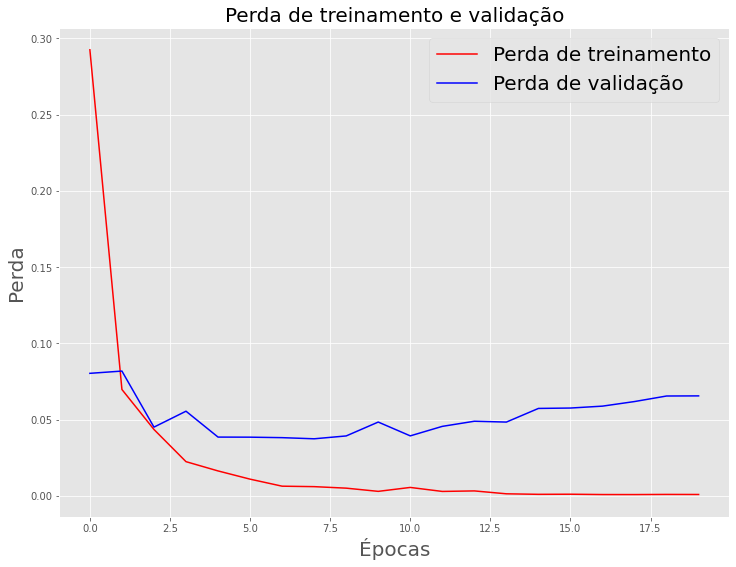

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(_history.epoch, _history_data['loss'], 'r', label='Perda de treinamento')
plt.plot(_history.epoch, _history_data['val_loss'], 'b', label='Perda de validação')
plt.title('Perda de treinamento e validação', size=20)
plt.xlabel('Épocas', size=20)
plt.ylabel('Perda', size=20)
plt.legend(prop={'size': 20})
plt.show()

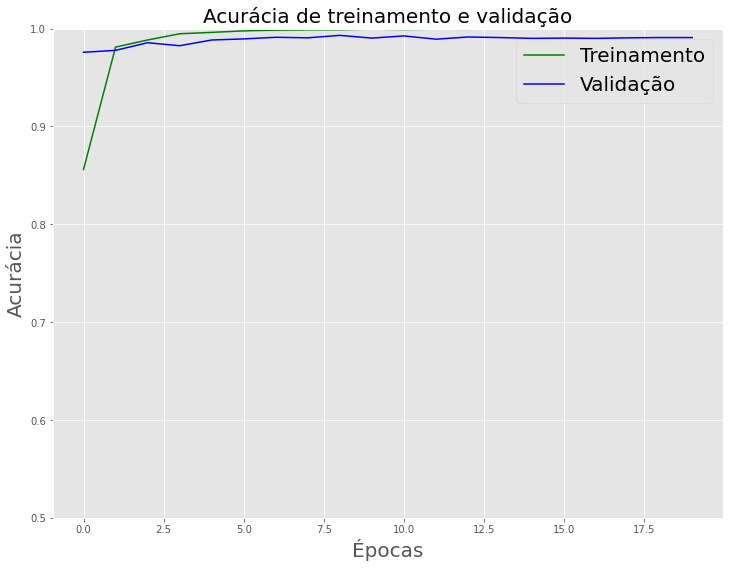

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(_history.epoch, _history_data['accuracy'], 'g', label='Treinamento')
plt.plot(_history.epoch, _history_data['val_accuracy'], 'b', label='Validação')
plt.title('Acurácia de treinamento e validação', size=20)
plt.xlabel('Épocas', size=20)
plt.ylabel('Acurácia', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [ ]:
_model.evaluate(X_test, y_test)
_binary_predictions = [1 if p >= 0.5 else 0 for p in _model.predict(X_test)]

print('Acurácia:', accuracy_score(_binary_predictions, y_test))
print('Precisão:', precision_score(_binary_predictions, y_test))

281/281 [==============================] - 21s 74ms/step - loss: 0.0621 - accuracy: 0.9906
Acurácia: 0.9906458797327394
Precissão: 0.9879573876794813


#Matriz de confusão

<p align="justify">A matriz de confusão evidencia os bons resultados dos testes de validação, indicando a quantidade de verdadeiros positivos e verdadeiros negativos muitos altos e se aproximando bastante do seu valor total. Enquanto a quantidade de falsos negativos é um pouco maior que a quantidade de falsos positivos, indicando que o modelo final tem a tendencia de considerar notícias como falsas com mais facilidade do que o contrário.</p>

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

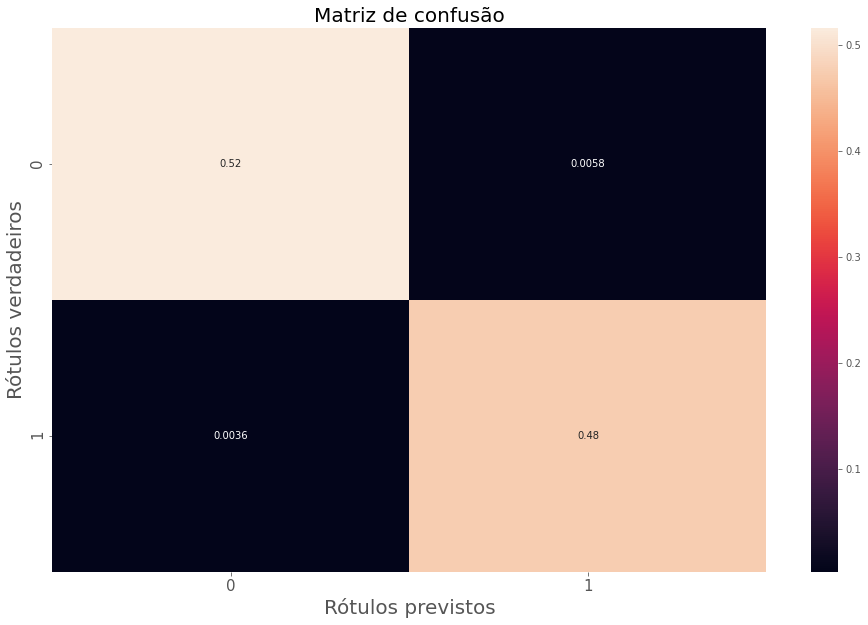

In [ ]:
_matrix = confusion_matrix(_binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax = plt.subplot()
sns.heatmap(_matrix, annot=True, ax = ax)

ax.set_xlabel('Rótulos previstos', size=20)
ax.set_ylabel('Rótulos verdadeiros', size=20)
ax.set_title('Matriz de confusão', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)